<a href="https://colab.research.google.com/github/EllaThomasson/labs-ds3001/blob/main/PCA_Lab_EllaThomasson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
! git clone https://github.com/DS3001/PCA

Cloning into 'PCA'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 12), reused 14 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 2.42 MiB | 8.12 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [6]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')

**Question 1**

In [4]:
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


I would first remove any whitespace within the tokens, so I just get each word. Next, I would delete all extremely common words that just fill sentences (words that likely don't mean anything and appear in just about all emails). Words like: "and", "is", "are", ... . Next, I would one-hot-encoded the tokens for each e-mail as features/covariates/predictors. Then I would run PCA and Linear Regression, which would use the presence of the tokens to predict whether or not the e-mails are scams.

**Question 2**

<Axes: >

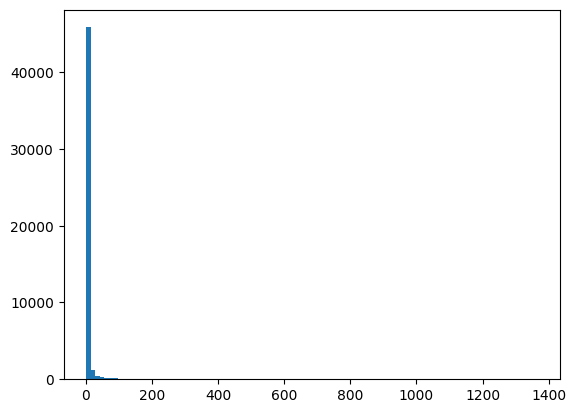

In [13]:
with open('/content/PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

Most tokens appear a small amount of times. 1 is by far the most common frequency, followed by 2. There are a few tokens that are outliers (and occur 1200/1400 times). To summarize, this distribution is very right skewed, with most words appearing once.

**Question 3**

In [17]:
df = pd.read_parquet('/content/PCA/05_PCA/Phishing_clean.parquet')

Part 1

In [20]:
y = df['Email Type']
X = df.drop('Email Type',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

Part 2

In [21]:
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train r^2: ', r2_score(y_hat_train_0,y_train) )
print('test r^2: ', r2_score(y_hat_test_0,y_test) )

train r^2:  0.6210107280960204
test r^2:  -0.00026838432670373


The training r^2 is fairly high, but the testing r^2 is worse than just predicting the mean. This suggests that the model is overfitting the data. This makes sense due to the fact that we have so many variables that are likely correlated.

Part 3

In [22]:
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


Numbers seem to have the largest coefficients in absolute value and most strongly influence prediction. This is not what we are looking for.

**Question 4**

<Axes: >

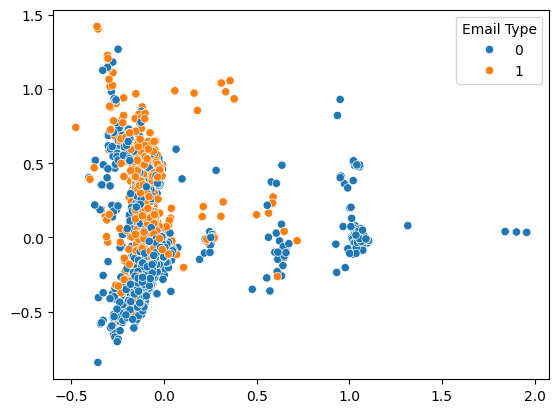

In [23]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The orange dots (which are the scam emails) are a bit lower with respect to the first principal component and a bit higher with respect to the second principal component.

**Question 5**

In [26]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r^2: ', r2_score(y_hat_train,y_train) )
print('Test r^2: ', r2_score(y_hat_test,y_test) )

Train r^2:  0.692897536096375
Test r^2:  0.5873905973217184


The test r^2 value is MUCH better after using PCA. The model no longer seems to be over-fitting the data.

**Question 6**

PCA appears to greatly decrease the overfitting that occurs in linear regression, due to multicollinearity. PCA is a form of dimentionality reduction, so it attempts to decorrelate the components, which makes the testing r^2 much closer to the training r^2. On the other hand, when using PCA, we can interpret words, but not what the components themselves are, which can be a bit confusing and makes it difficult to understand how the PCA is actually working.